In [1]:
pip install implicit

In [0]:
import pandas as pd
import numpy as np
import implicit
import os
from google.colab import files

from scipy import sparse

In [5]:
uploaded = files.upload()

Saving customers.csv to customers.csv


In [1]:
!ls

customers.csv  purchases_test.csv  purchases_train.csv	sample_data


In [3]:
purchases_train = pd.read_csv('purchases_train.csv')
purchases_train.head()

,customer_id,product_id,datetime
0,8698595,12530,2004-03-10 22:18:43.497459200
1,13271885,7541,2004-03-06 02:24:43.209763200
2,16852746,13134,2004-03-10 01:03:09.598614400
3,16852746,6572,2004-03-04 16:45:16.522566400
4,14619070,4659,2004-03-12 13:29:35.011481600


In [4]:
purchases_test = pd.read_csv('purchases_test.csv')
purchases_test.head()

,customer_id,product_id,datetime
0,1021292,6197,2004-03-18 13:35:19.145152000
1,11379978,4659,2004-03-19 18:51:31.887936000
2,13271885,5659,2004-03-14 05:47:21.544166400
3,13271885,1015,2004-03-15 14:41:19.702089601
4,12315337,12072,2004-03-19 10:39:17.148105600


In [0]:
purchases = pd.concat([purchases_train, purchases_test])

In [6]:
customers = pd.read_csv('customers.csv')
customers.head()

,customer_id,sex
0,14386819,Female
1,1481405,NaN
2,16745074,NaN
3,10325906,NaN
4,11167384,NaN


In [7]:
purch_tr = purchases.groupby('customer_id')['product_id'].apply(lambda s: s.values).reset_index()
purch_tr.rename(columns={'product_id': 'product_ids'}, inplace=True)
purch_tr.head()

,customer_id,product_ids
0,107,"[1542, 5449, 5868]"
1,351,[965]
2,357,[12654]
3,434,"[6771, 5868, 7754, 12043, 6735, 7290, 9408, 39..."
4,453,"[5868, 11854]"


In [8]:
purch_tr_1 = purch_tr.merge(customers, left_on='customer_id', right_on='customer_id', how='left')[['customer_id', 'sex', 'product_ids']]
purch_tr_1.head()

,customer_id,sex,product_ids
0,107,NaN,"[1542, 5449, 5868]"
1,351,NaN,[965]
2,357,NaN,[12654]
3,434,Female,"[6771, 5868, 7754, 12043, 6735, 7290, 9408, 39..."
4,453,Male,"[5868, 11854]"


In [9]:
df = purch_tr_1[(purch_tr_1.sex.notna())]
df.head()

,customer_id,sex,product_ids
3,434,Female,"[6771, 5868, 7754, 12043, 6735, 7290, 9408, 39..."
4,453,Male,"[5868, 11854]"
6,1011,Female,"[1093, 10515, 11822, 12667, 10609, 7110]"
8,1135,Female,"[3878, 1463, 8994]"
10,1376,Female,"[6461, 570]"


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# количество уникальных id покупателей
len(df['customer_id'])

31943

In [12]:
df['sex'].value_counts()

Female    23536
Male       8407
Name: sex, dtype: int64

Распределение покупателей по половой принадлежности
Female    0.736812
Male      0.263188
Name: sex, dtype: float64


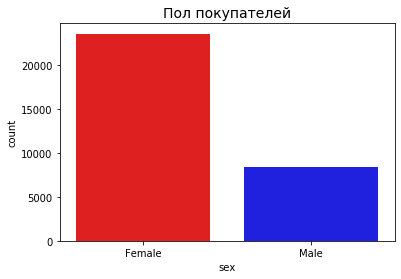

In [13]:
print('Распределение покупателей по половой принадлежности')
print(df['sex'].value_counts()/len(df))

colors = {'Male': 'b', 'Female': 'r'}

sns.countplot('sex', data=df, palette=colors)
plt.title('Пол покупателей', fontsize=14)
plt.show()

Выровняем классы путем копирования экземпляров класса меньшинства.

In [14]:
# Перемешаем данные перед созданием подвыборок
df = df.sample(frac=1)


female_df = df.loc[df['sex'] == 'Female']
male_df = df.loc[df['sex'] == 'Male']
# что бы количество было одинаково - скопируем все записи и добавим еще 6722 случайным образом
male_df_res = pd.concat([male_df, male_df, male_df.sample(n=6722)])

# объединение female_df и male_df
normal_distributed_df = pd.concat([female_df, male_df_res])

# Перемешиваем строки в наборе данных
new_df = normal_distributed_df.sample(frac=1, random_state=42).reset_index(drop=True)

new_df.head()

,customer_id,sex,product_ids
0,20514756,Female,"[10366, 13690, 2614, 5128]"
1,15117338,Male,"[9033, 4372]"
2,15488307,Male,"[6204, 11494, 5239, 9845, 7714, 8576, 4550, 19..."
3,19894733,Female,"[2446, 7290]"
4,20766334,Male,[4728]


In [15]:
new_df['sex'].value_counts()

Female    23536
Male      23536
Name: sex, dtype: int64

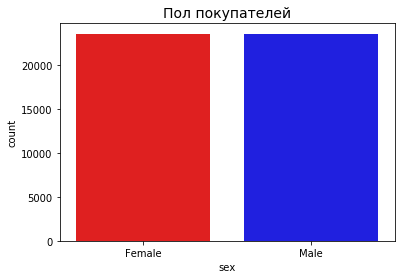

In [16]:
sns.countplot('sex', data=new_df, palette=colors)
plt.title('Пол покупателей', fontsize=14)
plt.show()

In [17]:
# удаляем столбец customer_id, что бы не мешался
# заменяем значения Female на 1, Male на 0

new_df = new_df.drop('customer_id', axis=1)
new_df['sex'] = new_df['sex'].map({'Female': 1, 'Male': 0})

new_df = new_df.reset_index(drop=True)
print('Female - 1, ', 'Male - 0')

new_df.head()

Female - 1,  Male - 0


,sex,product_ids
0,1,"[10366, 13690, 2614, 5128]"
1,0,"[9033, 4372]"
2,0,"[6204, 11494, 5239, 9845, 7714, 8576, 4550, 19..."
3,1,"[2446, 7290]"
4,0,[4728]


In [0]:
from sklearn.model_selection import train_test_split

x = new_df.drop('sex', axis=1)
y = new_df['sex']

In [19]:
from keras.preprocessing.sequence import pad_sequences

# maxlen - максимальное количество id товаров купленных одним покупателем
maxlen = 10
x = x['product_ids'].tolist()
y = y.values

x = pad_sequences(x, maxlen=maxlen, padding='post')

Using TensorFlow backend.


In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [21]:
# покупки покупателя
x_train[5]

array([5868,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [22]:
# пол покупателя
y_train[5]

1

In [0]:
# выравнивание классов
#from imblearn.under_sampling import RandomUnderSampler

# random oversampling
#ros = RandomOverSampler(random_state=42)
#x_train_res, y_train_res = ros.fit_resample(x_train, y_train)

In [24]:
print(x_train.shape, y_train.shape)

(37657, 10) (37657,)


In [0]:
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, Dropout
from keras import utils
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers

In [26]:
# количество уникальных id товаров
max_product = len(purchases['product_id'].unique())
print(max_product)

1799


In [27]:
model_nn = Sequential()
model_nn.add(Embedding(max_product, 2, input_length=maxlen))
model_nn.add(Dropout(0.25))
model_nn.add(Flatten())
model_nn.add(Dense(1, activation='sigmoid'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [28]:
model_nn.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [29]:
history = model_nn.fit(x_train, 
                    y_train, 
                    epochs=50,
                    batch_size=256,
                    validation_split=0.1,
                    verbose = 2)




Train on 33891 samples, validate on 3766 samples
Epoch 1/50





 - 1s - loss: 0.6914 - acc: 0.5301 - val_loss: 0.6886 - val_acc: 0.5661
Epoch 2/50
 - 0s - loss: 0.6877 - acc: 0.5543 - val_loss: 0.6839 - val_acc: 0.5836
Epoch 3/50
 - 0s - loss: 0.6821 - acc: 0.5691 - val_loss: 0.6769 - val_acc: 0.5887
Epoch 4/50
 - 0s - loss: 0.6768 - acc: 0.5792 - val_loss: 0.6708 - val_acc: 0.5905
Epoch 5/50
 - 0s - loss: 0.6709 - acc: 0.5846 - val_loss: 0.6658 - val_acc: 0.5969
Epoch 6/50
 - 0s - loss: 0.6677 - acc: 0.5879 - val_loss: 0.6617 - val_acc: 0.5990
Epoch 7/50
 - 0s - loss: 0.6648 - acc: 0.5882 - val_loss: 0.6596 - val_acc: 0.6012
Epoch 8/50
 - 0s - loss: 0.6638 - acc: 0.5889 - val_loss: 0.6576 - val_acc: 0.6033
Epoch 9/50
 - 0s - loss: 0.6623 - acc: 0.5901 - val_loss: 0.6567 - val_acc: 0.6059
Epoch 10/50
 - 0s - loss: 0.6613 - acc: 0.5911 - val_loss: 0.6554 - val_acc: 0.6033
Epoch 11/50
 - 0s - loss: 0.6618 - acc: 0.5872 - val_loss: 0.6549 - val_acc: 0.6030
Epoch 12/50
 - 0s - loss: 0.

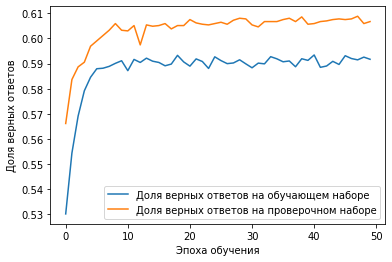

In [30]:
plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

**Получаем матрицу плотных векторных представлений товаров**

In [31]:
embedding_matrix = model_nn.layers[0].get_weights()[0]
embedding_matrix[:5]

array([[ 0.01283675, -0.03364468],
       [-0.00643514, -0.04679894],
       [-0.01227235, -0.00366832],
       [-0.04149725, -0.03379389],
       [-0.00714284,  0.023964  ]], dtype=float32)

**Визуализация плотных векторных представлений товаров**

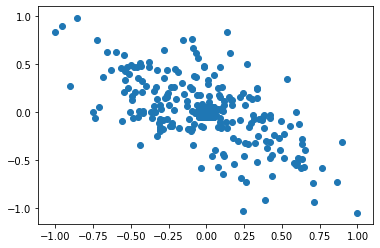

In [32]:
plt.scatter(embedding_matrix[:,0], embedding_matrix[:,1])

In [33]:
embedding_matrix

array([[ 0.01283675, -0.03364468],
       [-0.00643514, -0.04679894],
       [-0.01227235, -0.00366832],
       ...,
       [-0.04694242, -0.00774112],
       [ 0.25454906, -0.32646015],
       [ 0.03307653,  0.0407798 ]], dtype=float32)

**Выводы по классификации покупателей:**

- Наш классификатор определяет пол покупателя правильно для 60%, что всего лишь 
на 10% лучше случайного определения и на 13% хуже, если всех считать женщинами (жинщины составляеют 73% от покупателей у которых определен пол);
- Большая часть товаров на визуальном предстваление плотных векторов около точки (0.0; 0.0) - это значит, что их покупают примерно с одинаковой частотой люди обоих полов;
- Одна неделя - слишком малый срок для того, что бы покупатель набрал достаточно товаров для определения его пола;
- Использование такого классификатора бесплезно.

**Улучшение рекомендательной сисетмы**

Создадим спицаиальные рекомендательные сисетмы отдельно для покупателей каждого пола, а для тех, чей пол неизвестен - будем использовать общую рекомендательную систему, которая обучалась в начале этого ноутбука.